In [1]:
%load_ext autoreload
%autoreload 2

The autoreload module is not an IPython extension.


UsageError: Line magic function `%autoreload` not found.


In [1]:

from pathlib import Path
import numpy as np

import torch
from reverb.training.dataloaders import RawDataDataset
from reverb.analysis.inference import ML_Model_Inference, MaskGenerator, SimpleNameImageDataset, WhaleFinder

In [2]:
dirs = ["_spec_data_misc_", "_spec_data_37_46", "_spec_data_OBS",  "_spec_data_UP01_27", "_spec_data_28_36_"]

In [ ]:
h5_files = []
for dir in dirs:
    raw_data_dir = Path("../../../_outputs_/_spec_data_/" + dir + "/spectrogram_data")
    h5_files.extend(list(raw_data_dir.glob("*.h5")))

In [ ]:
match_string = 'UP13'
len([f for f in h5_files if match_string in str(f)])

In [3]:
whale_finding_folder = 'results/UPFLOW_array/blue_whales'

In [4]:
path_to_model = '/data/UPFLOW/projects/iReverb/reverb/data/whale_finder.pl_ckpt'

# model = ML_Model_Inference(path_to_model, device = 'cuda')

image_dataset = SimpleNameImageDataset(h5_files, padding=(0, 4, 0, 17))
# whale_finder = WhaleFinder(model, image_dataset, batch_size=100)


NameError: name 'h5_files' is not defined

In [4]:
whale_call_bands = [[7,8]]
spec_frequencies = np.linspace(1.01,20.01, 399)
whale_frequencies_mask = np.zeros(399, dtype='int64')
for band in whale_call_bands:
    start, end = band
    mask_indices = np.where((spec_frequencies >= start) & (spec_frequencies <= end))
    whale_frequencies_mask[mask_indices] = 1

In [5]:
# Don't need to rerun this every time! 
RERUN_LABELLING = False

if RERUN_LABELLING:
    whale_finder.find_and_save_whale_calls(
        whale_finding_folder, whale_frequencies_mask[::-1], threshold=10
    )


In [6]:
import h5py

def load_whale_mask(file):
    with h5py.File(file, 'r') as f:
        return np.array(f['mask'])

def pairwise(iterable):
    "s -> (s0, s1), (s2, s3), (s4, s5), ..."
    a = iter(iterable)
    return zip(a, a)

In [7]:
import h5py

def load_resonant_energy_array(file):
    with h5py.File(file, 'r') as f:
        return np.array(f['mask'])

def count_number_of_predicted_resonances(resonant_energy_array):
    return np.count_nonzero(resonant_energy_array)
    

In [6]:
NUM_JOBS = 10
import joblib
parallel_execution = lambda input_list, function: joblib.Parallel(n_jobs=NUM_JOBS)(joblib.delayed(function)(args) for args in input_list)

In [ ]:
whale_found_files = list(Path(whale_finding_folder).glob("*.h5"))

load_and_count_resonances = lambda file: count_number_of_predicted_resonances(load_resonant_energy_array(file))


In [ ]:
num_resonances_list = parallel_execution(whale_found_files, load_and_count_resonances)


In [ ]:
import matplotlib.pyplot as plt

# plot histogram of the number of resonances
plt.hist(num_resonances_list, bins=20)
plt.xlabel("Number of whale pixels")
plt.ylabel("Number of files")
plt.show()


In [8]:

import re
from datetime import datetime

def convert_filename_to_datetime(filename):
    # extract datetime from file name given the format
    # UP05_Z_2021.07.18-061500-2021.07.18-063000.h5
    pattern = r'(\d{4}\.\d{2}\.\d{2}-\d{6})'
    match = re.search(pattern, filename)
    datetime_str = match.group(1)
    datetime_obj = datetime.strptime(datetime_str, "%Y.%m.%d-%H%M%S")
    return datetime_obj

def get_datetime_and_num_resonances(file):
    filename = Path(file).name
    datetime_obj = convert_filename_to_datetime(filename)
    num_resonances = count_number_of_predicted_resonances(load_resonant_energy_array(file))
    return datetime_obj, num_resonances
def get_datetime_and_increment_counter(file):
    filename = Path(file).name
    datetime_obj = convert_filename_to_datetime(filename)
    return datetime_obj, 1

In [ ]:
datetime_resonance_counts = parallel_execution(whale_found_files, get_datetime_and_num_resonances)


In [ ]:
import pandas as pd

df = pd.DataFrame(datetime_resonance_counts, columns=['datetime', 'count'])

# Set the datetime column as the index
df.set_index('datetime', inplace=True)

# Resample the data by week and sum the counts
df_resampled = df.resample('W-Mon').sum()

# Plot the histogram
plt.bar(df_resampled.index, df_resampled['count'], width=5)  # Width can be adjusted
plt.xlabel('Week')
plt.ylabel('Total Number of Whale Call Pixels')
plt.title('Total Whale Call Count by Week')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


Computing the average resonant energy at specific frequencies is a little tricky because we want to filter out all the non-resonant pixels. See below (particularly 'compute_per_freq_energy_sums_and_counts') for an example of how to do this.

In [8]:
len(list(Path(whale_finding_folder).glob(f"*")))

109365

In [9]:
import pickle
from pathlib import Path
path = 'data/final_whale_call_counts.pkl'
if Path(path).exists():
    with open(path, 'rb') as f:
        station_whale_found_files = pickle.load(f)
else:
    with open(path, 'wb') as f:
        pickle.dump(station_whale_found_files, f)
station_counts = {station: sum([count for _, count in res]) for station, res in station_whale_found_files.items()}

# for station, res in station_whale_found_files.items():
#     print(station, len(res), station_counts[station])

In [68]:
def generate_latex_table_columnwise(data_dict, columns=3):
    import math
    from itertools import zip_longest

    # Preserve order
    items = list(data_dict.items())
    total = len(items)

    # Calculate number of rows needed per column
    rows_per_column = math.ceil(total / columns)

    # Split items into columns, each with up to `rows_per_column` entries
    columns_data = [items[i * rows_per_column:(i + 1) * rows_per_column] for i in range(columns)]

    # Pad shorter columns with empty entries
    padded_columns = [col + [('', '')] * (rows_per_column - len(col)) for col in columns_data]

    # Transpose columns into rows
    table_rows = list(zip(*padded_columns))  # Each row contains 1 station–count from each column

    # Build LaTeX table
    col_format = '||'.join(['ll'] * columns)
    lines = [
        f"\\begin{{tabular}}{{{col_format}}}",
        "\\toprule",
        ' & '.join(['Station & Count'] * columns) + " \\\\",
        "\\midrule"
    ]

    for row in table_rows:
        row_str = ' & '.join([f"{station} & {count}" if station else '' for station, count in row])
        lines.append(row_str + " \\\\")

    lines.append("\\bottomrule")
    lines.append("\\end{tabular}")

    return '\n'.join(lines)

# Example usage
station_counts = {k: v for k, v in station_counts.items() if v > 0}
latex_code = generate_latex_table_columnwise(station_counts, columns=3)
print(latex_code)


\begin{tabular}{ll||ll||ll}
\toprule
Station & Count & Station & Count & Station & Count \\
\midrule
UP01 & 1926 & UP17 & 373 & UP33 & 11921 \\
UP02 & 10235 & UP18 & 19720 & UP34 & 19639 \\
UP03 & 2907 & UP19 & 10520 & UP35 & 13186 \\
UP04 & 6268 & OBS17 & 14463 & UP36 & 4112 \\
UP05 & 5161 & OBS19 & 22152 & UP37 & 34 \\
UP06 & 23487 & UP20 & 19911 & UP38 & 956 \\
UP07 & 12072 & UP22 & 15244 & UP39 & 6271 \\
UP08 & 4887 & UP24 & 30333 & UP40 & 5173 \\
UP09 & 900 & UP25 & 27294 & UP41 & 22355 \\
UP11 & 8654 & UP27 & 8695 & UP42 & 8076 \\
UP12 & 9868 & UP28 & 1252 & UP43 & 6558 \\
UP13 & 5702 & UP29 & 11431 & UP45 & 3354 \\
X25 & 19153 & UP32 & 23674 & UP46 & 3825 \\
OBS12 & 15941 & UP31 & 15369 &  \\
UP16 & 9989 & UP30 & 9376 &  \\
\bottomrule
\end{tabular}


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import ndimage as ndi
from datetime import timedelta
from reverb.analysis.plotting import get_spectrogram_colors
dir = dirs[1]


def plot_whale_calls_spectrogram(station_name: str, start_index: int):
    # Parameters
    minutes_per_file = 15
    files_needed = 8  # 2 hours
    min_size = 6
    duration = minutes_per_file * 60

    # File paths
    found_whales = Path(whale_finding_folder).glob(f'*{station_name}*')
    found_whales = sorted(found_whales, key=lambda x: convert_filename_to_datetime(x.name))
    
    raw_data_dir = Path("../../../_outputs_/_spec_data_/" + dir + "/spectrogram_data")

    spectrograms = []
    masks = []
    timestamps = []

    for file in found_whales[start_index:start_index + files_needed]:
        data_filepath = raw_data_dir / file.name
        img = RawDataDataset.load_image(data_filepath, pad=(0, 0, 0, 0))
        spectrograms.append(img[0])

        try:
            mask = load_whale_mask(file)
        except FileNotFoundError:
            mask = np.zeros_like(img[0], dtype=bool)
        
        masks.append(mask)
        timestamps.append(convert_filename_to_datetime(file.name))

    # Combine spectrograms and masks
    full_spectrogram = np.concatenate(spectrograms, axis=1)
    full_mask = np.concatenate(masks, axis=1)

    # Frequency selection
    spec_frequencies = np.linspace(1.01, 50.0, 399)
    freq_mask = (spec_frequencies >= 15) & (spec_frequencies <= 19)
    freq_indices = np.where(freq_mask)[0]
    cropped_spectrogram = np.flipud(np.flipud(full_spectrogram)[freq_indices, :])
    cropped_frequencies = spec_frequencies[freq_indices][::-1]
    cropped_mask = np.flipud(np.flipud(full_mask)[freq_indices, :])

    # Call extraction
    start_time = timestamps[0]
    total_duration = files_needed * duration
    labeled, num_features = ndi.label(cropped_mask)
    whale_calls = []

    for region_idx in range(1, num_features + 1):
        region = np.argwhere(labeled == region_idx)
        if len(region) < min_size:
            continue
        mean_x = np.mean(region[:, 1])
        x_fraction = mean_x / cropped_mask.shape[1]
        call_time = start_time + timedelta(seconds=x_fraction * total_duration + 60)
        whale_calls.append(call_time)

    # Plotting
    fig, ax = plt.subplots(figsize=(15, 3))
    ax.imshow(get_spectrogram_colors(cropped_spectrogram, vlims=(-210, -180), cmap='plasma'), aspect='auto')

    # Title with station and date
    formatted_date = start_time.strftime('%d.%m.%Y')
    ax.set_title(f"{station_name} - {formatted_date}")

    # Y-axis: 16Hz and 18Hz only
    desired_freqs = [16, 18]
    ytick_indices = [np.argmin(np.abs(cropped_frequencies - f)) for f in desired_freqs]
    ax.set_yticks(ytick_indices)
    ax.set_yticklabels([str(f) for f in desired_freqs])
    ax.set_ylabel("Frequency (Hz)")

    # X-axis: time ticks every 15 minutes
    num_time_ticks = files_needed + 1
    x_tick_locs = np.linspace(0, cropped_spectrogram.shape[1], num_time_ticks)
    x_tick_labels = [(start_time + timedelta(minutes=15 * i)).strftime("%H:%M") for i in range(num_time_ticks)]
    ax.set_xticks(x_tick_locs)
    ax.set_xticklabels(x_tick_labels, rotation=45)
    ax.set_xlabel("Time")

    # Annotate calls
    for call_time in whale_calls:
        x_fraction = (call_time - start_time).total_seconds() / total_duration
        x_pos = x_fraction * cropped_spectrogram.shape[1]
        ax.axvline(x=x_pos, color='white', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig(f"whale_calls_{station_name}_{start_index}.svg", dpi=300)
    plt.show()


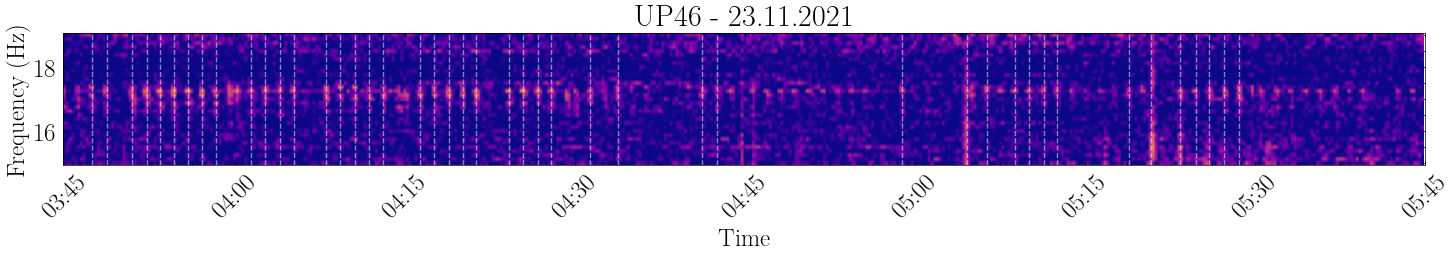

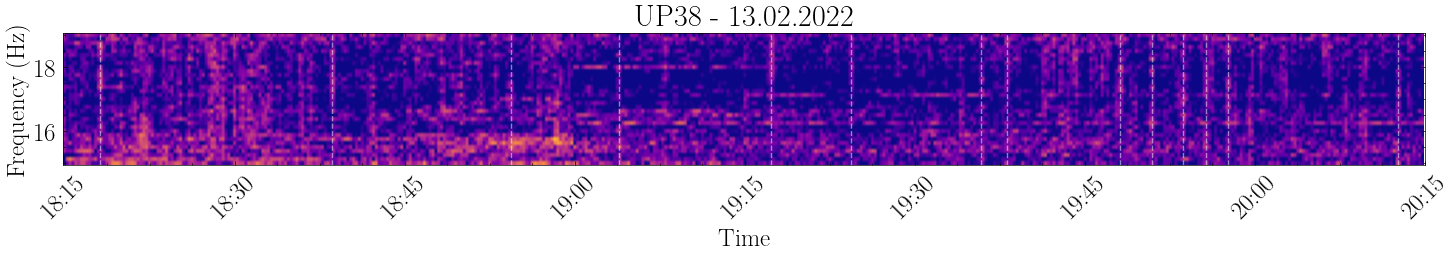

In [58]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 18})
with plt.style.context('science'):
    plot_whale_calls_spectrogram("UP46", start_index=450)
    plot_whale_calls_spectrogram("UP38", start_index=400)



    # plot_whale_calls_spectrogram("UP02", start_index=00)





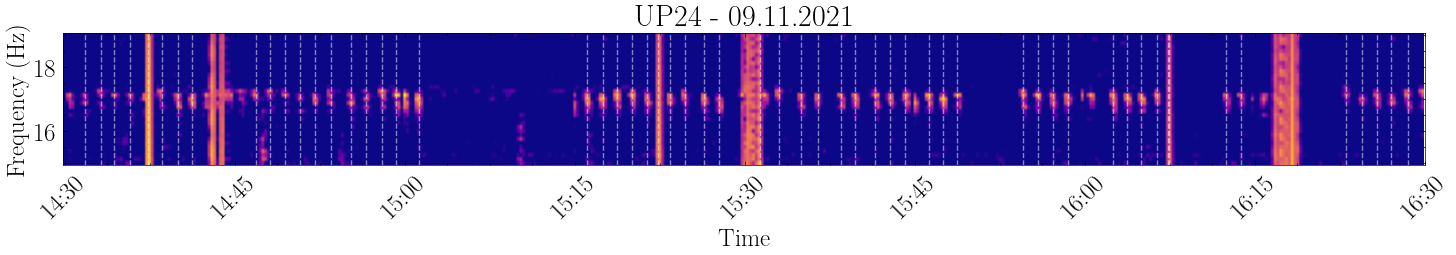

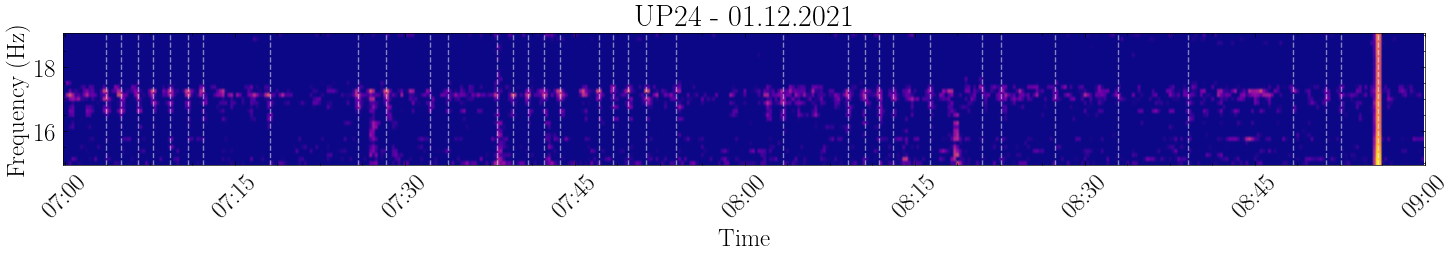

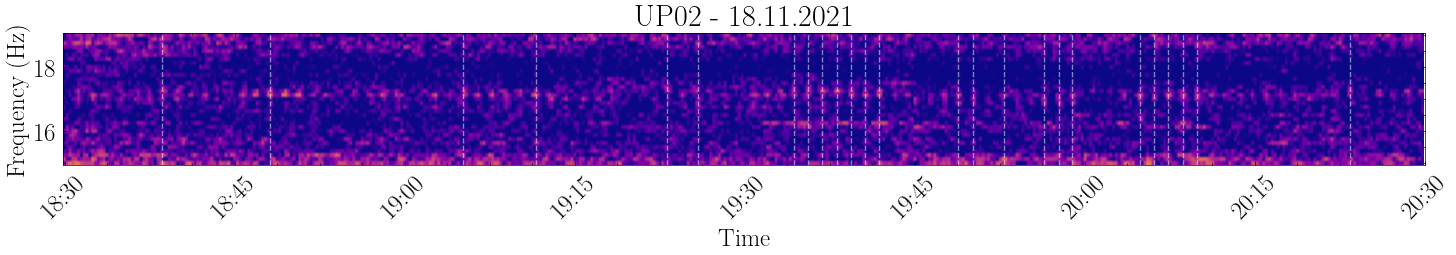

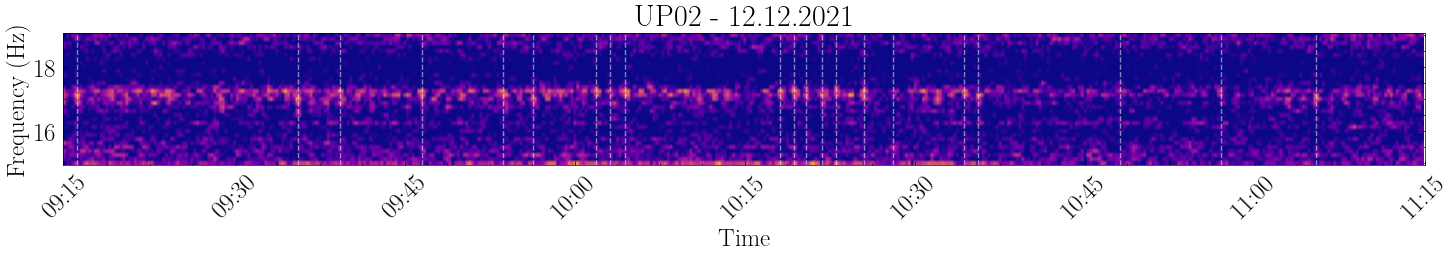

In [47]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 18})
dir = dirs[3]
with plt.style.context('science'):
    plot_whale_calls_spectrogram("UP24", start_index=500)
    plot_whale_calls_spectrogram("UP24", start_index=1800)
    plot_whale_calls_spectrogram("UP02", start_index=1000)
    plot_whale_calls_spectrogram("UP02", start_index=2000)

    # plot_whale_calls_spectrogram("UP02", start_index=00)





In [ ]:
import matplotlib.pyplot as plt
from reverb.analysis.plotting import get_spectrogram_colors
found_whales = Path(whale_finding_folder).glob('*UP02*')
found_whales = list(found_whales)
found_whales = sorted(found_whales, key=lambda x: convert_filename_to_datetime(x.name))
print(len(found_whales))
dir = dirs[3]
raw_data_dir = Path("../../../_outputs_/_spec_data_/" + dir + "/spectrogram_data")
colors = ['darkblue','cyan']
cmap = plt.cm.colors.ListedColormap(colors)
spec_frequencies = np.linspace(1.01,50.0, 399)
# plot spectrogram alongside mask
num_plots = 10
for file_pair in pairwise(found_whales[680:752]):
    fig, axes = plt.subplots(1, 4, figsize=(15, 20))
    
    for i, file in enumerate(file_pair):
        data_filepath = raw_data_dir / file.name
        img = RawDataDataset.load_image(data_filepath, pad=(0,0,0,0))
        mask = load_whale_mask(file)
        # number of non-zero pixels in mask
        axes[2*i].imshow(get_spectrogram_colors(img[0]))
        axes[2*i + 1].imshow(mask, cmap)
        axes[2*i].set_title(file.name)

        indices = np.linspace(0, 398, 50, dtype='int64')
        for ax in axes.flat:
            ax.set_xticks([])
            ax.set_xticklabels([])
            ax.set_yticks(indices[::4])
            ax.set_yticklabels(list(map(round,spec_frequencies[indices[::-1][::4]])))
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    

In [ ]:
import numpy as np
# whitespace delimieter
station_data = np.loadtxt('data/UPFLOW_STATIONS', dtype=str, delimiter='\t')
azores_stations = station_data[:, 0]
#lat lon
station_map = {}
for station in azores_stations:
    lat, lon = station_data[station_data[:, 0] == station, 2:4][0].astype(float)
    station_map[station] = (lat, lon)

In [ ]:
azores_whale_found_files = {station: list(Path(whale_finding_folder).glob(f"*{station}*")) for station in azores_stations}
datetime_detections = {station: [get_datetime_and_increment_counter(file) for file in found_files]
                            for station, found_files in azores_whale_found_files.items()}

In [ ]:
import scipy.ndimage as ndi
import numpy as np
from pathlib import Path
from tqdm import tqdm

def count_whale_calls(file, threshold=6):
    filename = Path(file).name
    datetime_obj = convert_filename_to_datetime(filename)
    mask = load_whale_mask(file)
    # Count the number of connected components in the mask
    labeled_array, num_features = ndi.label(mask)
    # count number of features above threshold
    num_calls = sum([1 for i in range(1, num_features + 1) if np.sum(labeled_array == i) > threshold])
    return datetime_obj, num_calls

station_whale_found_files = {station: [count_whale_calls(file) for file in tqdm(found_files)]
                            for station, found_files in azores_whale_found_files.items()}

In [ ]:
import pickle
from pathlib import Path
path = 'data/final_whale_call_counts.pkl'
if Path(path).exists():
    with open(path, 'rb') as f:
        station_whale_found_files = pickle.load(f)
else:
    with open(path, 'wb') as f:
        pickle.dump(station_whale_found_files, f)
station_counts = {station: sum([count for _, count in res]) for station, res in station_whale_found_files.items()}

# for station, res in station_whale_found_files.items():
#     print(station, len(res), station_counts[station])

In [ ]:
import pandas as pd

# Create DataFrames for each station and resample weekly
station_dataframes = {}

for station, data in station_whale_found_files.items():
    df = pd.DataFrame(data, columns=['datetime', station])
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    
    # Resample to get weekly counts
    station_dataframes[station] = df.resample('W').sum()

# Merge all stations into a single DataFrame
weekly_counts = pd.concat(station_dataframes.values(), axis=1).fillna(0)

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import haversine_distances

all_stations_distances = {}
anchor_lat = 42
anchor_lon = -33  # Fixed typo
anchor_coords = np.radians([[anchor_lat, anchor_lon]])  # Convert to radians

for station in azores_stations:
    station_coords = np.radians([[station_map[station][0], station_map[station][1]]])  # Convert to radians
    all_stations_distances[station] = haversine_distances(anchor_coords, station_coords)[0][0] * 6371  # Multiply by Earth's radius in km

print(all_stations_distances)


In [ ]:
min_dist = min(all_stations_distances.values())
max_dist = max(all_stations_distances.values())
normed_all_stations_distances = {station: (dist - min_dist) / (max_dist - min_dist) for station, dist in all_stations_distances.items()}

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import lfilter

n = 3           # Larger n gives smoother curves
b = [1.0 / n] * n  # Numerator coefficients for filtering
a = 1              # Denominator coefficient
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,10))

cmap = plt.get_cmap('jet')

# Find the full date range across all stations
all_datetimes = []
for station in azores_stations:
    if datetime_detections[station]:
        all_datetimes.extend([entry[0] for entry in datetime_detections[station]])

if not all_datetimes:
    raise ValueError("No data available.")

min_date, max_date = min(all_datetimes), max(all_datetimes)
full_index = pd.date_range(start=min_date, end=max_date, freq='W-Mon')  # Weekly on Mondays
full_index = pd.to_datetime(full_index).normalize() 
for station in azores_stations:
    datetime_detection_counts = datetime_detections[station]
    if len(datetime_detection_counts) == 0:
        continue

    df = pd.DataFrame(datetime_detection_counts, columns=['datetime', 'count'])
    df.set_index('datetime', inplace=True)

    # Resample to weekly intervals
    df_resampled = df.resample('W-Mon').sum()
    final = df_resampled.reindex(full_index).fillna(0)
    # Reindex with full index, interpolate missing values, and fill out-of-bounds with 0
    # final = df_resampled.reindex(full_index).interpolate(method='linear')#.fillna(0)

    # Normalize and apply smoothing filter
    data = 100 * final['count'] / (24 * 4 * 7)  # Normalize by time
    data = lfilter(b, a, data)  # Apply smoothing filter

    # Plot the histogram
    plt.plot(
        final.index, 
        data, 
        label=station, 
        color=cmap(normed_all_stations_distances[station]), 
        alpha=0.7
    )
plt.legend(loc='upper left', fontsize=8)
plt.xlabel('Week')
plt.ylabel('Percentage of Time with Whale Calls (%)')
plt.title('Whale Call Activity by Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from scipy.signal import lfilter
n = 3           # Larger n gives smoother curves
b = [1.0 / n] * n  # Numerator coefficients for filtering
a = 1              # Denominator coefficient
weekly_station_plots= [['UP18', 'UP16', 'OBS12', 'X25'], ['UP20', 'UP22', 'UP24', 'UP25'], ['UP45', 'UP46', 'UP38', 'UP37']]
import scienceplots
save_fig_names = ['north', 'south', 'east']
with plt.style.context(['science'] ):
    for i, station_group in enumerate(weekly_station_plots):
        plt.figure(figsize=(6,5))
        #apply smoothing filter
        # data = lfilter(b, a, weekly_counts)
        # Plot the histogram
        for station in station_group:
            plt.semilogy(
                weekly_counts.index, 
                weekly_counts[station], 
                label=station, 
                # color=cmap(normed_all_stations_distances[station]), 
                alpha=0.7,
                linewidth=2
            )
        plt.ylim(bottom=10)
        plt.legend(loc='upper right')
        plt.xlabel('Date')
        plt.ylabel('Weekly Whale Call Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f'{save_fig_names[i]}.png', dpi=200, transparent=True)
        plt.show()

In [ ]:
import numpy as np
import cartopy.crs as ccrs
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LightSource
import cmocean
import os
import matplotlib.patches as mpatches

In [ ]:
path_to_file = 'data/station_list_simple_plotting.txt' 
station_list = np.loadtxt(path_to_file, dtype=object)

In [ ]:
leg1 = station_list[:28]
leg2 = station_list[27:]

lisbon_lon = float(station_list[0,9])- float(station_list[0,10])/60
lisbon_lat = float(station_list[0,7])+ float(station_list[0,8])/60

ponta_lon = float(station_list[27,9])- float(station_list[27,10])/60
ponta_lat = float(station_list[27,7])+ float(station_list[27,8])/60

leg1_lons = leg1[:,9].astype(float)- leg1[:,10].astype(float)/60
leg1_lats = leg1[:,7].astype(float)+ leg1[:,8].astype(float)/60
leg1_depth = leg1[:,4].astype(float)/np.max(leg1[:,4].astype(float))*100
leg1_names = leg1[:,0]
leg1_oroig = leg1[:,1]


leg2_lons = leg2[:,9].astype(float)- leg2[:,10].astype(float)/60
leg2_lats = leg2[:,7].astype(float)+ leg2[:,8].astype(float)/60
leg2_depth = leg2[:,4].astype(float)/np.max(leg2[:,4].astype(float))*100
leg2_names = leg2[:,0]
leg2_orig = leg2[:,1]



depth = station_list[:,4].astype(float)/np.max(station_list[:,4].astype(float))*100
names = station_list[:,0]
orig = station_list[:,1]
up_names = station_list[:,2]
statyp = station_list[:,5]
shift_lon = station_list[:,11].astype(float)
shift_lat = station_list[:,12].astype(float)


os.environ["CARTOPY_USER_BACKGROUNDS"] = "data/grids/"

In [ ]:
alpha = 0.7

fontsize = 15

save_name = 'UPFLOW_EOS_highres_map_no_labels'

# extent = [-35, -7, 27, 43]

extent = [-36, -5, 26, 44]

ls = LightSource(azdeg=315, altdeg=45)

filename = f'/home/maria/Codes/grids/extent_{extent[0]}_{extent[1]}_{extent[2]}_{extent[3]}.tiff'



with rasterio.open(filename, 'r') as src:

# read image into ndarray

im = src.read()

# transpose the array from (band, row, col) to (row, col, band)

im = np.transpose(im, [1,2,0])



divnorm = mcolors.TwoSlopeNorm(vmin=-6000, vcenter=0, vmax=2500)

# plot raster

rgb = ls.shade(im.reshape(np.shape(im)[0], np.shape(im)[1]), norm=divnorm, cmap=cmocean.cm.topo)

In [ ]:
import rasterio
import numpy as np
import matplotlib.colors as mcolors
import cmocean # Make sure cmocean is installed: pip install cmocean
from matplotlib.colors import LightSource # Assuming LightSource is from here

# --- Your provided setup ---
alpha = 0.7
fontsize = 15
save_name = 'UPFLOW_EOS_highres_map_no_labels'
original_extent = [-36, -5, 26, 44] # Renamed for clarity [min_lon, max_lon, min_lat, max_lat]
ls = LightSource(azdeg=315, altdeg=45)
# Use the original_extent to build the filename
filename = f'/home/maria/Codes/grids/extent_{original_extent[0]}_{original_extent[1]}_{original_extent[2]}_{original_extent[3]}.tiff'

# Define the new desired extent
new_extent = [-36, -10, 29, 42.5] # [min_lon, max_lon, min_lat, max_lat]

# --- Load image and get necessary info BEFORE closing the file ---
try:
    with rasterio.open(filename, 'r') as src:
        # Read image data into ndarray
        im_raw = src.read() # Shape is (band, row, col)
        # --- Get georeferencing info and calculate pixel indices ---
        # The transform maps pixel coordinates (col, row) to geographic coordinates (lon, lat)
        transform = src.transform

        # Use src.index() to convert geographic coordinates (lon, lat) to pixel indices (row, col)
        # Note: Latitude generally decreases as row index increases.
        # Top-left corner of new extent (minimum longitude, maximum latitude)
        row_start, col_start = src.index(new_extent[0], new_extent[3])

        # Bottom-right corner of new extent (maximum longitude, minimum latitude)
        row_end_inclusive, col_end_inclusive = src.index(new_extent[1], new_extent[2])
        
        # Get the shape for checking bounds later (bands, rows, cols)
        original_shape_bands_rows_cols = im_raw.shape
        print(f"Original raster shape (bands, rows, cols): {original_shape_bands_rows_cols}")
        print(f"Calculated row indices: start={row_start}, end_inclusive={row_end_inclusive}")
        print(f"Calculated col indices: start={col_start}, end_inclusive={col_end_inclusive}")

    # --- Transpose the array AFTER reading ---
    # from (band, row, col) to (row, col, band)
    im = np.transpose(im_raw, [1, 2, 0])
    print(f"Transposed image shape (rows, cols, bands): {im.shape}")

    # --- Slice the image array ---
    # Python slicing is exclusive of the end index, so we add 1 to the inclusive end indices.
    # Also, ensure indices stay within the array bounds [0, max_index]
    max_row_index = im.shape[0] - 1
    max_col_index = im.shape[1] - 1

    # Clamp indices to valid range to prevent errors if new_extent is outside original
    row_start_clamped = max(0, row_start)
    col_start_clamped = max(0, col_start)
    # Add 1 for slicing's exclusive end, then clamp to the total dimension size
    row_end_sliced = min(im.shape[0], row_end_inclusive + 1)
    col_end_sliced = min(im.shape[1], col_end_inclusive + 1)

    print(f"Using clamped slice indices:")
    print(f"  Rows: {row_start_clamped} to {row_end_sliced}")
    print(f"  Cols: {col_start_clamped} to {col_end_sliced}")

    # Perform the slice using clamped indices
    im_cropped = im[row_start_clamped:row_end_sliced, col_start_clamped:col_end_sliced, :]

    print(f"Cropped image shape (rows, cols, bands): {im_cropped.shape}")

    # --- Continue with your processing on the cropped image ---
    # Check if cropping resulted in a valid image
    if im_cropped.size == 0:
        print("Warning: Cropping resulted in an empty image. Check new_extent and original coverage.")
    else:
        # Reshape for shading if necessary (assuming single band or shading first band)
        if im_cropped.shape[2] == 1:
             im_cropped_2d = im_cropped.reshape(im_cropped.shape[0], im_cropped.shape[1])
        else:
             # If multi-band, decide which band to shade (e.g., the first one)
             print("Warning: Multi-band image detected. Shading will be applied to the first band.")
             im_cropped_2d = im_cropped[:, :, 0]

        divnorm = mcolors.TwoSlopeNorm(vmin=-6000, vcenter=0, vmax=2500) # Use the same norm for now

        # Apply light source shading to the cropped 2D data
        rgb_cropped = ls.shade(im_cropped_2d, norm=divnorm, cmap=cmocean.cm.topo)


        print("Successfully cropped and shaded the image.")
        # If you plot this using imshow, remember to use `new_extent` for the extent parameter:
        # plt.imshow(rgb_cropped, extent=new_extent) # Or extent=[new_extent[0], new_extent[1], new_extent[2], new_extent[3]]

except FileNotFoundError:
    print(f"Error: File not found at {filename}")
except rasterio.RasterioIOError as e:
    print(f"Error reading raster file: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(30, 20))

# define cartopy crs for the raster, based on rasterio metadata
crs = ccrs.PlateCarree()

# create figure
ax = plt.axes(projection=crs)

plt.figure
# plt.title('test')

ax.set_xmargin(0.05)
ax.set_ymargin(0.10)

center = 0
lons = station_list[:,9].astype(float)- station_list[:,10].astype(float)/60
lats = station_list[:,7].astype(float)+ station_list[:,8].astype(float)/60

# scatter_bubble_sizes = np.log10(np.array([station_counts.get(station, 0) for station in up_names]) + 1)**3*50
scatter_bubble_sizes = np.array([station_counts.get(station, 0) for station in up_names])/4
# remove all stations with no detections
lons = lons[scatter_bubble_sizes > 0]
lats = lats[scatter_bubble_sizes > 0]
stations = up_names[scatter_bubble_sizes > 0]
scatter_bubble_sizes = scatter_bubble_sizes[scatter_bubble_sizes > 0]

plt.scatter(lons, lats,
            linewidth=3, edgecolor='red', s=scatter_bubble_sizes,
            color="none", zorder=10, 
            transform=crs)

plt.scatter(lons, lats, marker='x',
            linewidth=3, edgecolor='black', s=50,
            color="white", zorder=10, 
            transform=crs)

sizes = [1000, 5000, 15000]
scaled_sizes = [count /4 for count in sizes]  # Adjust the scaling factor to match your plot
scales = [1., -1., -0.6]
for i, station_group in enumerate(weekly_station_plots):
    # plt the text
    for station in station_group:
        # get the index of the station
        station_index = np.where(stations == station)[0][0]
        # get the coordinates of the station
        lon = lons[station_index]
        lat = lats[station_index]
        # plot the text
        plt.text(
            lon, lat + scales[i], station,
            fontsize=20, ha='center', va='center', color='black',
            transform=crs, weight='bold',
            bbox=dict(
                boxstyle="round,pad=0.3",  # Rounded box with padding
                edgecolor="black",         # Black outline
                facecolor="lightgray",     # Light gray background
                linewidth=2                # Thickness of the border
            )
        )
# Create dummy scatter plot for legend
scatter_legends = [ax.scatter([], [], s=size,  edgecolor='red', color='none', linewidth=2, transform=crs) for size in scaled_sizes]

# Create custom legend with bubble sizes
labels = [f"{size} calls" for size in sizes]
legend = ax.legend(scatter_legends, labels, loc="upper right", fontsize=22, title="Bubble Size (total calls)", markerscale=1, labelspacing=2, borderpad=1.5)

# Set the background to be semi-opaque (framealpha controls transparency)
legend.get_frame().set_alpha(0.7)  # Set alpha to 0.5 for semi-transparency
legend.get_frame().set_facecolor('white')  # Set background color to white

gl = ax.gridlines(draw_labels=True, alpha=0.7)
gl.xlines = False
gl.ylines = False
# gl.top_labels = False
# gl.right_labels = False
gl.xlabel_style = {'size': 20, 'color': 'gray', 'weight': 'bold'}
gl.ylabel_style = {'size': 20, 'color': 'gray', 'weight': 'bold'}
extent=[-36, -10, 29, 42.5]
im = plt.imshow(rgb_cropped, origin='upper', extent=extent, transform=crs, interpolation='nearest', norm=divnorm, cmap=cmocean.cm.topo)
ax.coastlines()

cax = fig.add_axes([ax.get_position().x1 + 0.05, ax.get_position().y0, 0.02, ax.get_position().height])
fig.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)

plt.savefig('total_whale_call_counts.svg', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean
import pandas as pd
import matplotlib.animation as animation
plt.rcParams.update({'font.size': 20})

# Load weekly data
weeks = weekly_counts.index
stations = weekly_counts.columns
total_counts = weekly_counts.sum(axis=1) # Sum over all stations for time series

lons = station_list[:,9].astype(float)- station_list[:,10].astype(float)/60
lats = station_list[:,7].astype(float)+ station_list[:,8].astype(float)/60

# scatter_bubble_sizes = np.log10(np.array([station_counts.get(station, 0) for station in up_names]) + 1)**3*50
scatter_bubble_sizes = np.array([station_counts.get(station, 0) for station in up_names])/4
# remove all stations with no detections
lons = lons[scatter_bubble_sizes > 0]
lats = lats[scatter_bubble_sizes > 0]

# Set up the figure with two subplots
crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(30, 25))

# Create a GridSpec layout to control subplot heights
gs = fig.add_gridspec(2, 1, height_ratios=[1, 3])

# Create first subplot (map) with Cartopy projection
ax = fig.add_subplot(gs[1], projection=crs)

# Create second subplot (time series) without projection
ax_ts = fig.add_subplot(gs[0])

# Set margins
ax.set_xmargin(0.05)
ax.set_ymargin(0.10)

# Plot base map (this stays fixed)
im = ax.imshow(rgb, origin='upper', extent=extent, transform=crs, 
                interpolation='nearest', norm=divnorm, cmap=cmocean.cm.topo)
ax.coastlines()

# Add grid labels
gl = ax.gridlines(draw_labels=True, alpha=0.7)
gl.xlabel_style = {'size': 20, 'color': 'gray', 'weight': 'bold'}
gl.ylabel_style = {'size': 20, 'color': 'gray', 'weight': 'bold'}

# Add a colorbar
cax = fig.add_axes([ax.get_position().x1 + 0.05, ax.get_position().y0, 0.02, ax.get_position().height])
fig.colorbar(im, cax=cax)

# Initialize scatter plot
scatter = ax.scatter([], [], linewidth=3, edgecolor='red', s=[], 
                    color="none", zorder=10, transform=crs)

# ---- Time Series Subplot ----
ax_ts.plot(weeks, total_counts, color='blue', linewidth=3, label="Total Calls per Week")
week_marker = ax_ts.axvline(x=weeks[0], color='red', linewidth=3, linestyle='--')  # Vertical red line

# Add a text object to display the current total calls
text_annotation = ax_ts.text(weeks[0] + pd.Timedelta(1, 'D'), total_counts.max() * 0.9, "", color='black', fontsize=28)

ax_ts.set_xlim(weeks.min(), weeks.max())
ax_ts.set_ylim(0, total_counts.max() * 1.1)  # Add 10% buffer for aesthetics
ax_ts.set_ylabel("Total Calls", fontsize=20)
ax_ts.set_xlabel("Week", fontsize=20)
ax_ts.legend(fontsize=20)
ax_ts.grid(True, linestyle="--", alpha=0.5)

sizes = [10, 100, 1000]
scaled_sizes = [count * 4 for count in sizes]  # Adjust the scaling factor to match your plot

# Create dummy scatter plot for legend
scatter_legends = [ax.scatter([], [], s=size,  edgecolor='red', color='none', linewidth=2, transform=crs) for size in scaled_sizes]

# Create custom legend with bubble sizes
labels = [f"{size} calls/week" for size in sizes]
legend = ax.legend(scatter_legends, labels, loc="upper right", fontsize=22, title="Bubble Size (calls/week)", markerscale=1, labelspacing=2, borderpad=1.5)

# Set the background to be semi-opaque (framealpha controls transparency)
legend.get_frame().set_alpha(0.7)  # Set alpha to 0.5 for semi-transparency
legend.get_frame().set_facecolor('white')  # Set background color to white

# ---- Animation Functions ----
def init():
    scatter.set_offsets(np.empty((0, 2)))  # Empty 2D array
    scatter.set_sizes([])
    week_marker.set_xdata(weeks[0])  # Initialize vertical line
    text_annotation.set_text("")  # Initialize the text as empty
    return scatter, week_marker, text_annotation

def update(frame):
    week = weeks[frame]  # Get current week
    counts = weekly_counts.loc[week]  # Get counts for this week

    # Compute bubble sizes
    scatter_bubble_sizes = counts * 4

    # Update scatter plot
    scatter.set_offsets(np.column_stack((lons, lats)))
    scatter.set_sizes(scatter_bubble_sizes)

    # Update vertical line position in time series
    week_marker.set_xdata(week)

    # Update the title for the map plot
    ax.set_title(f"Week: {week.strftime('%Y-%m-%d')}", fontsize=24, color='black')

    # Update the time series text with the current total calls for the week
    total_calls = total_counts.loc[week]
    
    # Move the text slightly to the right of the vertical line (1 day offset here)
    text_annotation.set_position((week + pd.Timedelta(2, 'D'), total_counts.max() * 0.9))
    text_annotation.set_text(f"{int(total_calls)} Calls")  # Update text with total calls

    return scatter, week_marker, text_annotation

# Create animation with blitting
ani = animation.FuncAnimation(fig, update, frames=len(weeks), init_func=init, interval=1000, blit=True)

# Save animation
ani.save('weekly_whale_calls.mp4', fps=3, dpi=100)

plt.show()
